In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from PIL import Image

import kagglehub

In [3]:
# Téléchargement de la dernière version du dataset CelebA depuis Kaggle
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print("Path to dataset files:", path)

# Définir le chemin vers le dossier contenant les images et le CSV.
# Ici, on suppose que le dataset téléchargé contient un dossier "img_align_celeba"
DATA_PATH = os.path.join(path, "img_align_celeba")



Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [19]:
# --- Hyperparameters ---
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 1
BETA = 2000  # Weight on KL divergence term (β-VAE)
LOAD_MODEL = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
attr_csv = os.path.join(path, "list_attr_celeba.csv")



# 1: Dataset Preparation and Exploration

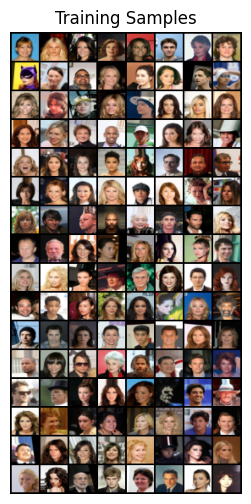

In [21]:

# Transformation : redimensionner les images à 32x32 et les convertir en tenseurs (valeurs dans [0,1])
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# Création du dataset via ImageFolder.
# Comme ImageFolder attend une structure de sous-dossiers, on utilise le dossier parent de DATA_PATH.
train_dataset = datasets.ImageFolder(
    root=os.path.dirname(DATA_PATH),  # Par exemple, si DATA_PATH est "…/img_align_celeba",
                                       # le dossier parent est celui qui contient "img_align_celeba"
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

# Utility: afficher une grille d'images
def show_batch(images, title=""):
    grid_img = utils.make_grid(images, nrow=8)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis("off")
    plt.show()

# Affichage d'un batch d'exemples
data_iter = iter(train_loader)
images, _ = next(data_iter)
show_batch(images, title="Training Samples")

## Model Architecture

In [22]:
# 2.1 Encoder
class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.z_dim = z_dim
        self.net = nn.Sequential(
            nn.Conv2d(CHANNELS, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.flatten = nn.Flatten()
        # Avec IMAGE_SIZE=32 et 4 couches de stride=2, la sortie est de taille 32/(2**4)=2, donc fc_in_features = NUM_FEATURES * 2 * 2
        fc_in_features = NUM_FEATURES * (IMAGE_SIZE // 2**4) ** 2
        self.mu = nn.Linear(fc_in_features, z_dim)
        self.logvar = nn.Linear(fc_in_features, z_dim)

    def forward(self, x):
        x = self.net(x)
        x = self.flatten(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

# 2.2 Sampling (Reparameterization)
class Sampling(nn.Module):
    def forward(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

# 2.3 Decoder
class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.z_dim = z_dim
        fc_out_features = NUM_FEATURES * (IMAGE_SIZE // 2**4) ** 2
        self.fc = nn.Sequential(
            nn.Linear(z_dim, fc_out_features),
            nn.BatchNorm1d(fc_out_features),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(NUM_FEATURES, CHANNELS, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, NUM_FEATURES, IMAGE_SIZE // 2**4, IMAGE_SIZE // 2**4)
        x = self.deconv(x)
        return x

# 2.4 Assemblage du modèle VAE
class VAE(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.encoder = Encoder(z_dim)
        self.sampling = Sampling()
        self.decoder = Decoder(z_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.sampling(mu, logvar)
        recon = self.decoder(z)
        return mu, logvar, recon, z

# 3: VAE Loss Function

In [23]:
def vae_loss_fn(x, recon, mu, logvar, beta=BETA):
    # 1) Reconstruction Loss (MSE)
    recon_loss = F.mse_loss(recon, x, reduction="sum")
    # 2) KL Divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))
    kl_loss = kl / x.size(0)
    total_loss = recon_loss + kl_loss * (beta / x.size(0))
    return total_loss, recon_loss, kl_loss


# 4: Training Loop

In [24]:
model = VAE(z_dim=Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Début de l'entraînement du VAE sur CelebA...")
for epoch in range(EPOCHS):
    model.train()
    total_loss_val = 0.0
    total_rec_val = 0.0
    total_kl_val = 0.0

    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        mu, logvar, recon, _ = model(x)
        loss, rec_loss, kl_loss = vae_loss_fn(x, recon, mu, logvar, beta=BETA)
        loss.backward()
        optimizer.step()
        total_loss_val += loss.item()
        total_rec_val += rec_loss.item()
        total_kl_val += kl_loss.item()

    avg_loss = total_loss_val / len(train_loader)
    avg_rec = total_rec_val / len(train_loader)
    avg_kl = total_kl_val / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f} | Recon: {avg_rec:.4f} | KL: {avg_kl:.4f}")

# Sauvegarde du modèle entraîné
os.makedirs("./models", exist_ok=True)
torch.save(model.state_dict(), "./models/vae_face.pt")
model.eval()

Début de l'entraînement du VAE sur CelebA...
Epoch [1/1] | Loss: 6945.2619 | Recon: 5568.5082 | KL: 88.1122


VAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2, inplace=True)
      (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_

# 5: Generating and Saving Images

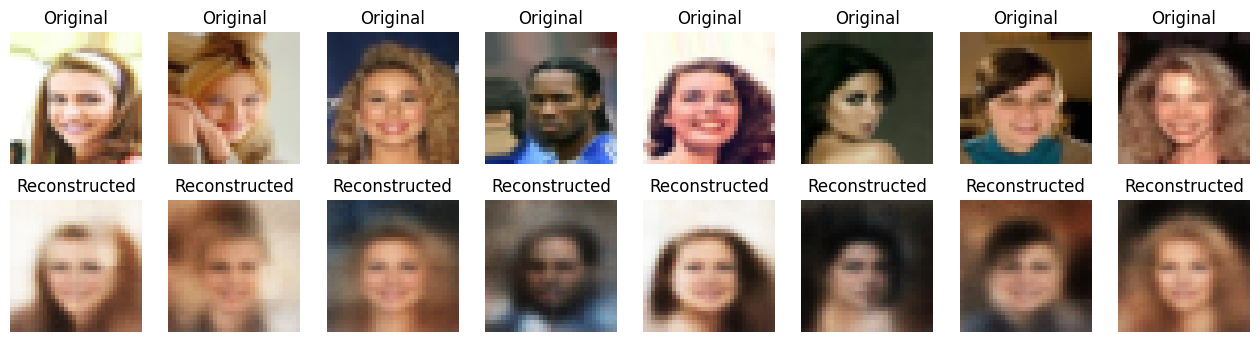

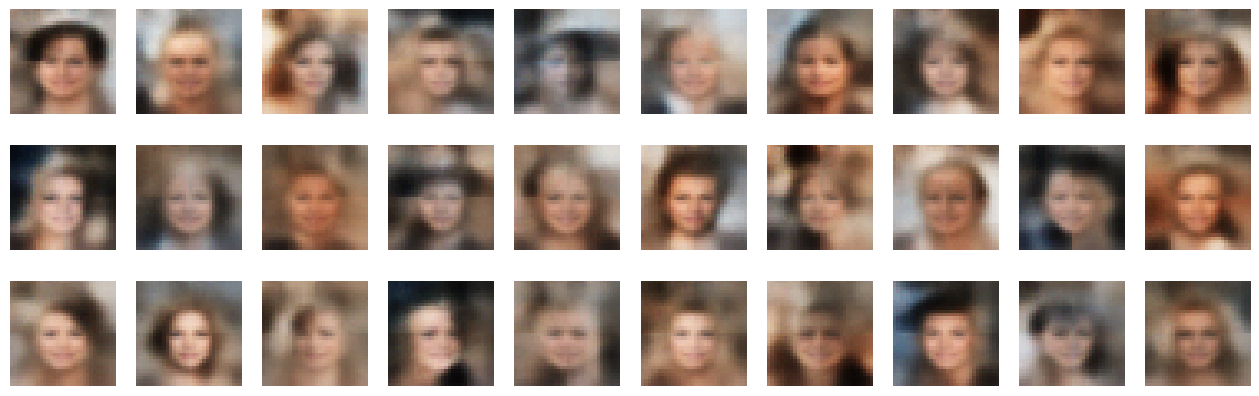

In [25]:
data_iter = iter(train_loader)
images, _ = next(data_iter)
images = images[:8].to(DEVICE)

with torch.no_grad():
    mu, logvar, recon, _ = model(images)

def show_reconstructions(orig, recon):
    n = orig.size(0)
    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(orig[i].permute(1,2,0).cpu().numpy())
        plt.title("Original")
        plt.axis("off")
    for i in range(n):
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i].permute(1,2,0).detach().cpu().numpy())
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

show_reconstructions(images, recon)

# Génération d'images à partir de vecteurs latents échantillonnés
grid_width, grid_height = 10, 3
z_sample = torch.randn((grid_width * grid_height, Z_DIM)).to(DEVICE)
with torch.no_grad():
    recon_gen = model.decoder(z_sample).detach()

def show_generated(recon, w=grid_width, h=grid_height):
    recon = recon.cpu()
    fig = plt.figure(figsize=(16, 5))
    for i in range(w*h):
        ax = fig.add_subplot(h, w, i+1)
        ax.axis("off")
        ax.imshow(recon[i].permute(1,2,0).numpy())
    plt.show()

show_generated(recon_gen)

# 7: Building a Custom Dataset with Attributes

In [32]:
LABEL = "Blond_Hair"  # Exemple d'attribut

class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, img_folder, attr_csv, label=LABEL, transform=None):
        self.transform = transform
        self.img_folder = img_folder
        self.df = pd.read_csv(attr_csv)
        self.label = label
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_name = row["image_id"]  # Adapter si nécessaire
        # --- Changed Code ---
        path = os.path.join(self.img_folder, "img_align_celeba", file_name) # Added "img_align_celeba" to the path
        # --- End of Changed Code ---
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label_val = row[self.label]
        label_val = 0 if label_val == -1 else 1
        return image, label_val


label_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

img_folder = DATA_PATH  # Les images se trouvent dans DATA_PATH
attr_csv = os.path.join(path, "list_attr_celeba.csv")
label_dataset = CelebADataset(img_folder, attr_csv, label=LABEL, transform=label_transform)
label_loader = DataLoader(label_dataset, batch_size=BATCH_SIZE, shuffle=True)


# 8: Extracting an Attribute Vector in Latent Space

In [33]:
def get_vector_from_label(loader, vae, embedding_dim, label_name="Attribute", max_samples=10000):
    device = next(vae.parameters()).device
    vae.eval()

    current_sum_POS = np.zeros(embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(embedding_dim, dtype="float32")

    current_vector = np.zeros(embedding_dim, dtype="float32")
    current_dist = 0.0

    print(f"label: {label_name}")
    print("images : POS move : NEG move : distance : Δ distance")

    for images, attributes in loader:
        images = images.to(device)
        attributes = attributes.to(device)

        with torch.no_grad():
            mu, logvar, recon, z = model(images)
        z_np = z.detach().cpu().numpy()  # (N, embedding_dim)
        attr_np = attributes.detach().cpu().numpy()  # (N,)

        mask_pos = np.where(attr_np == 1)[0]
        mask_neg = np.where(attr_np == 0)[0]

        z_POS = z_np[mask_pos]
        z_NEG = z_np[mask_neg]

        if len(z_POS) > 0:
            old_mean_POS = current_mean_POS.copy()
            current_sum_POS += np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            current_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(current_mean_POS - old_mean_POS)
        else:
            movement_POS = 0.0

        if len(z_NEG) > 0:
            old_mean_NEG = current_mean_NEG.copy()
            current_sum_NEG += np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            current_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(current_mean_NEG - old_mean_NEG)
        else:
            movement_NEG = 0.0

        current_vector = current_mean_POS - current_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(f"{current_n_POS} : {movement_POS:.3f} : {movement_NEG:.3f} : {new_dist:.3f} : {dist_change:.3f}")

        current_dist = new_dist

        if current_n_POS >= max_samples and current_n_NEG >= max_samples:
            pass
        if (movement_POS + movement_NEG) < 0.08 and new_dist > 1e-8:
            current_vector /= new_dist
            print(f"Found the {label_name} vector")
            break

    return current_vector

feature_vec = get_vector_from_label(label_loader, model, embedding_dim=Z_DIM, label_name=LABEL)


label: Blond_Hair
images : POS move : NEG move : distance : Δ distance
21 : 3.585 : 1.600 : 3.910 : 3.910
44 : 2.270 : 0.995 : 2.999 : -0.911
70 : 1.218 : 0.575 : 2.614 : -0.385
92 : 0.811 : 0.417 : 2.548 : -0.066
113 : 0.543 : 0.290 : 2.526 : -0.022
126 : 0.407 : 0.282 : 2.454 : -0.073
141 : 0.390 : 0.211 : 2.435 : -0.019
161 : 0.385 : 0.191 : 2.423 : -0.011
181 : 0.388 : 0.149 : 2.497 : 0.073
201 : 0.309 : 0.134 : 2.549 : 0.053
219 : 0.292 : 0.134 : 2.546 : -0.003
235 : 0.225 : 0.121 : 2.600 : 0.053
249 : 0.215 : 0.107 : 2.605 : 0.005
269 : 0.228 : 0.095 : 2.598 : -0.007
294 : 0.221 : 0.085 : 2.592 : -0.006
313 : 0.190 : 0.084 : 2.584 : -0.008
339 : 0.223 : 0.076 : 2.618 : 0.034
360 : 0.170 : 0.086 : 2.618 : -0.000
378 : 0.161 : 0.079 : 2.615 : -0.003
402 : 0.169 : 0.070 : 2.594 : -0.021
420 : 0.156 : 0.066 : 2.604 : 0.010
434 : 0.126 : 0.063 : 2.564 : -0.041
460 : 0.147 : 0.060 : 2.581 : 0.017
474 : 0.117 : 0.061 : 2.560 : -0.020
491 : 0.109 : 0.048 : 2.563 : 0.002
509 : 0.110 : 0.0

# 9: Using the Attribute Vector

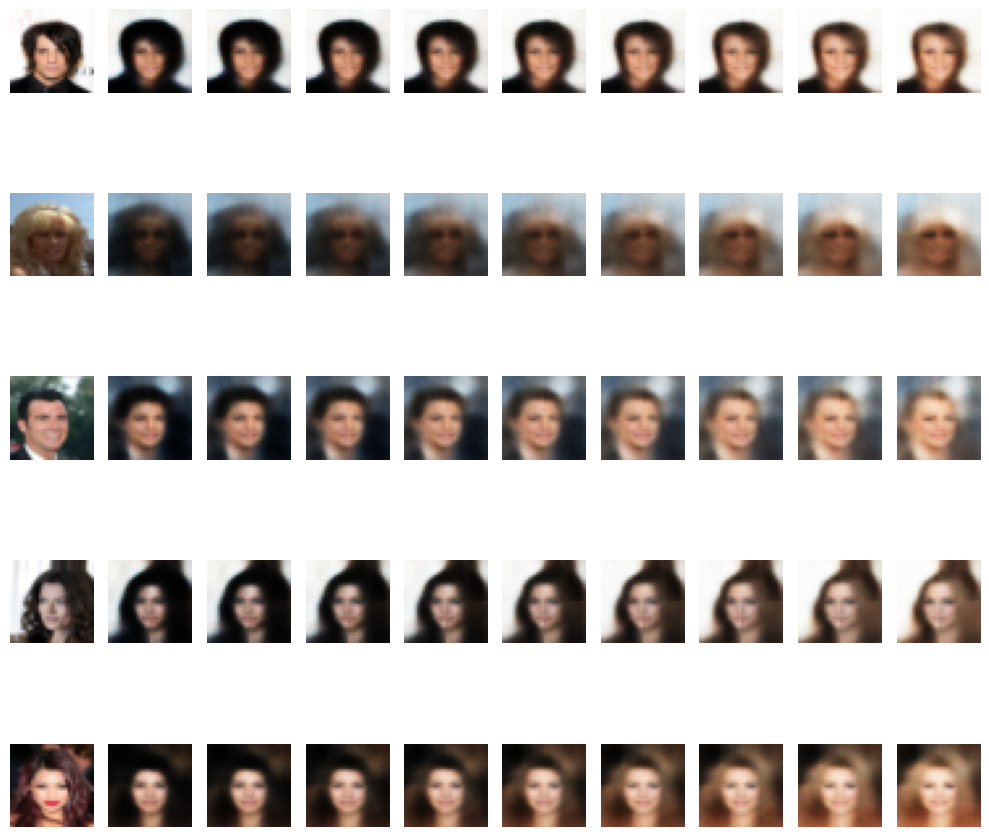

In [34]:
def add_vector_to_images(loader, vae, feature_vec, factors=None):
    if factors is None:
        factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    device = next(vae.parameters()).device
    vae.eval()

    images, _ = next(iter(loader))
    images = images.to(device)

    with torch.no_grad():
        _, mu, logvar, z = vae(images)

    n_to_show = min(5, images.size(0))
    fig = plt.figure(figsize=(len(factors)+1, n_to_show * 2))
    counter = 1
    for i in range(n_to_show):
        orig_img = images[i].detach().cpu().permute(1,2,0).numpy()
        ax = fig.add_subplot(n_to_show, len(factors)+1, counter)
        counter += 1
        ax.axis("off")
        ax.imshow(orig_img)
        for f in factors:
            base_z = z[i].detach().cpu().numpy()
            changed_z = base_z + feature_vec * f
            changed_z_torch = torch.from_numpy(changed_z).unsqueeze(0).float().to(device)
            with torch.no_grad():
                recon = vae.decoder(changed_z_torch)
                recon_img = recon[0].detach().cpu().permute(1,2,0).numpy()
            ax = fig.add_subplot(n_to_show, len(factors)+1, counter)
            counter += 1
            ax.axis("off")
            ax.imshow(recon_img)
    plt.tight_layout()
    plt.show()

add_vector_to_images(label_loader, model, feature_vec)

# 9.2 Morph Faces Between Two Latent Codes

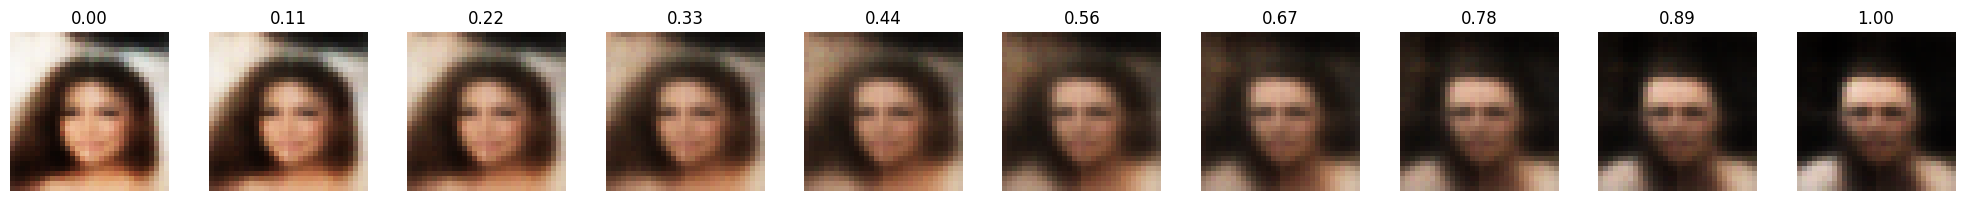

In [35]:
def morph_faces(loader, vae, steps=10):
    device = next(vae.parameters()).device
    vae.eval()

    images, _ = next(iter(loader))
    images = images[:2].to(device)
    if images.size(0) < 2:
        print("Not enough images in the batch to morph.")
        return

    with torch.no_grad():
        _, mu, logvar, z = vae(images)

    zA = z[0].detach().cpu().numpy()
    zB = z[1].detach().cpu().numpy()

    factors = np.linspace(0, 1, steps)
    plt.figure(figsize=(2*steps, 2))
    idx = 1
    for alpha in factors:
        inter_z = zA * (1 - alpha) + zB * alpha
        inter_z_torch = torch.from_numpy(inter_z).unsqueeze(0).float().to(device)
        with torch.no_grad():
            recon = vae.decoder(inter_z_torch)
        recon_img = recon[0].detach().cpu().permute(1,2,0).numpy()
        ax = plt.subplot(1, steps, idx)
        idx += 1
        ax.imshow(recon_img)
        ax.set_title(f"{alpha:.2f}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

morph_faces(label_loader, model, steps=10)

In [40]:
import torch
import matplotlib.pyplot as plt

# On suppose que les variables suivantes sont déjà définies dans ton code :
# - VAE, DEVICE, Z_DIM, train_loader
# - Les fonctions show_reconstructions(orig, recon) et show_generated(recon, w, h)

# Charger le modèle pré-entraîné depuis "content/vae_face.pt"
model = VAE(z_dim=Z_DIM).to(DEVICE)
model.load_state_dict(torch.load("/content/vae_face.pt", map_location=DEVICE))
model.eval()
print("Modèle chargé avec succès depuis content/vae_face.pt.")

Modèle chargé avec succès depuis content/vae_face.pt.


<ipython-input-40-692c2e931763>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/vae_face.pt", map_location=DEVICE))


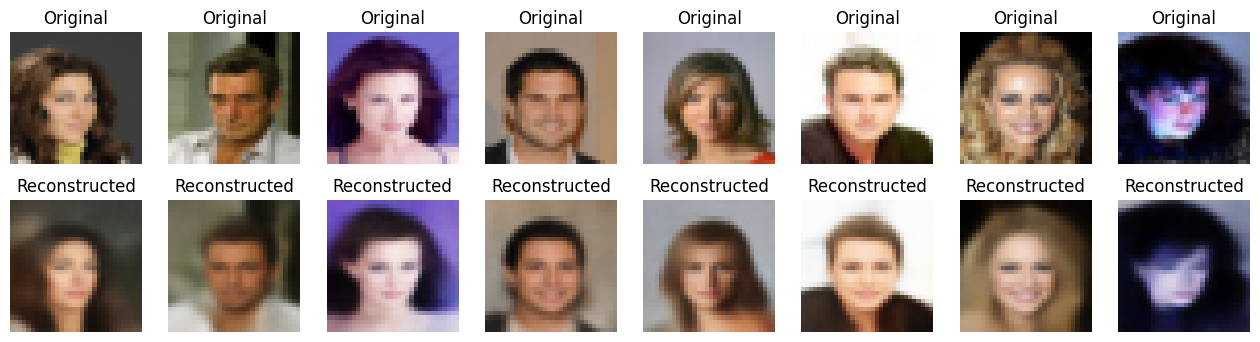

In [41]:
# -----------------------------
# 1. Afficher des reconstructions
# -----------------------------
# Récupérer un batch d'images depuis le DataLoader
data_iter = iter(train_loader)
images, _ = next(data_iter)
# On prend les 8 premières images pour la visualisation
images = images[:8].to(DEVICE)

with torch.no_grad():
    mu, logvar, recon, z = model(images)

# Afficher les images originales et leurs reconstructions
show_reconstructions(images, recon)

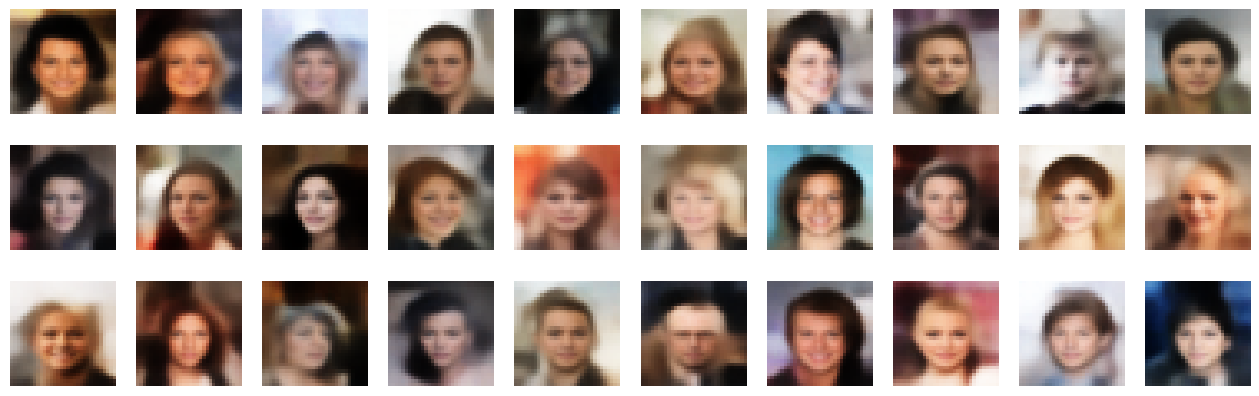

In [42]:
# -----------------------------
# 2. Générer de nouvelles images
# -----------------------------
# Générer un échantillon de vecteurs latents depuis une distribution normale
grid_width, grid_height = 10, 3
z_sample = torch.randn((grid_width * grid_height, Z_DIM)).to(DEVICE)

with torch.no_grad():
    recon_gen = model.decoder(z_sample).detach()

# Afficher les images générées
show_generated(recon_gen)

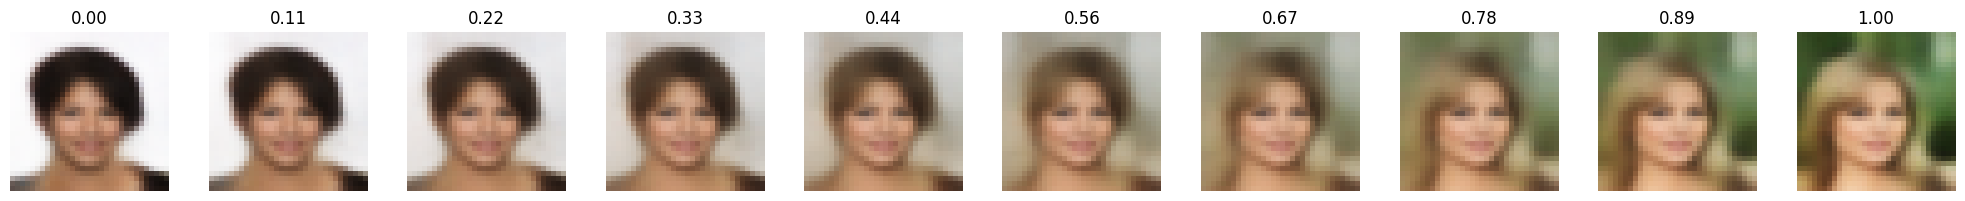

In [51]:
# Utiliser la fonction de morph_faces pour interpoler entre deux visages
morph_faces(train_loader, model, steps=10)